In [1]:
ENV["PYTHONPATH"] = "/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg";
D = 2;
using HDF5, PyPlot
using DelimitedFiles, PyPlot, LinearAlgebra, JLD2, PyCall, StaticArrays, Statistics
using Crystalline, Brillouin, MPBUtils, SymmetryBases
using Crystalline: TEST_αβγs, TEST_αβγ, dot, norm
using Crystalline: normscale, matching_littlegroups
using Crystalline: AbstractFourierLattice
topology_paper_dir = "../../TopologyPaper/"
include(topology_paper_dir * "get-freqs-symeigs.jl")
include(topology_paper_dir * "symeigs-from-io.jl");
include("../../Topology_ML/Phc_ML/fft.jl")
include("../get_uc_coefs.jl");
np = pyimport("numpy");

In [8]:
# Symmetry vectors corresponding to the eight classes
ns = [[0, 1, 0, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 0, 1, 1, 0, 1], 
[0, 1, 0, 1, 1, 0, 1, 0, 1], [0, 1, 1, 0, 1, 0, 1, 0, 1], [1, 0, 0, 1, 0, 1, 1, 0, 1], 
[1, 0, 1, 0, 0, 1, 1, 0, 1], [1, 0, 0, 1, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, 1, 0, 1]];
obstructed_idxs = [2, 3, 5, 8];
topological_idxs = [1, 4, 6, 7];

In [109]:
root_dir_smooth = "./inverse_design_two_tone_symbols_random/"
root_dir_two_tone = "./inverse_design_two_tone_symbols_random/"

contrast_dispersion_dir = root_dir_two_tone * "changing_contrast/dispersion/output/sg2/tm/contrast6/"
contrast_dispersion_log_dir = root_dir_two_tone * "changing_contrast/dispersion/logs/"
contrast_dir = root_dir_two_tone * "changing_contrast/output/sg2/tm/contrast6/"
smooth_dir = root_dir_smooth * "output/sg2/tm/"
two_tone_dir = root_dir_two_tone * "output/sg2/tm/";
edge_state_dir = root_dir_two_tone * "changing_contrast/edge_states/output/sg2/tm/contrast6/";
edge_state_log_dir = root_dir_two_tone * "changing_contrast/edge_states/logs/";


In [11]:
expect_to_be_good = []
for n in range(0, 7)
    filename = "two_tone_scores-class$(n).h5"
    f = h5open(root_dir_two_tone * filename, "r")
    which_good = findall(x-> x == n, np.argmax(f["two_tone_classifications"][], axis=0))
    push!(expect_to_be_good, which_good)
end

Load all symmetry data for smooth, two-tone and high-contrast PhCs

In [17]:
filename = "sg2-tm.jld2";
loaded_data = load(smooth_dir * filename);
N = 250
symmetries_smooth = [[x[1].n for x in loaded_data["summariesv"][1+topological_class*N:(topological_class+1)*N]] for topological_class in range(0, 7)];
filename = "sg2-tm.jld2";
loaded_data_two_tone = load(two_tone_dir * filename);
symmetries_two_tone = [[x[1].n for x in loaded_data_two_tone["summariesv"][1+topological_class*N:(topological_class+1)*N]] for topological_class in range(0, 7)];
loaded_data_v = []
for contrast_idx in 1:6
    contrast_dir = "./inverse_design_two_tone_symbols_random/changing_contrast/output/sg2/tm/contrast$(contrast_idx)/"
    filename = "sg2-tm-contrast$(contrast_idx).jld2";
    loaded_data = load(contrast_dir * filename);
    push!(loaded_data_v, loaded_data)
end
symmetries_contrasts = [[[x[1].n for x in loaded_data_v[contrast_idx]["summariesv"][1+topological_class*N:(topological_class+1)*N]] for topological_class in range(0, 7)] for contrast_idx in range(1, 6)];
filtered_high_contrast =[ findall(y -> y == ns[idx], x[expect_to_be_good[idx]]) for (idx, x) in enumerate(symmetries_contrasts[contrast_idx])] for contrast_idx in range(1, 6)];

In [89]:
filtered_high_contrast = [[(idx-1)*N .+ expect_to_be_good[idx][findall(y -> y == ns[idx], x[expect_to_be_good[idx]])] for (idx, x) in enumerate(symmetries_contrasts[contrast_idx])] for contrast_idx in range(1, 6)];

In [78]:
filtered_two_tone = vcat([(idx-1)*N .+ expect_to_be_good[idx][findall(y-> y == ns[idx], x[expect_to_be_good[idx]])] for (idx, x) in enumerate(symmetries_two_tone)]...);

In [80]:
filtered_all = intersect([[vcat(filtered_high_contrast[contrast_idx]...) for contrast_idx in range(1, 6)]..., filtered_two_tone]...);

In [101]:
obstructed_idxs_filtered = filter(x-> div(x-1, N) + 1 in obstructed_idxs, filtered_all) 
topological_idxs_filtered = filter(x-> div(x-1, N) + 1 in topological_idxs, filtered_all);

In [83]:
f = jldopen(contrast_dispersion_log_dir * "sg2-contrast_idx6-tm-log.jld2")
logsv = f["logsv"];
close(f)

In [84]:
dispersionsv_high_contrast = Matrix{Float64}[];
kpts = Vector{Float64}()
for (id, logstr) in enumerate(logsv)
    dispersion_str = logs_to_dispersion(logstr, "tm");
    dispersion = readdlm(IOBuffer(dispersion_str), ',')[:, 6:end]
    dispersion = sort(dispersion, dims=2)
    push!(dispersionsv_high_contrast, dispersion)
    kpts = readdlm(IOBuffer(dispersion_str), ',')[:, 2:4];
    (id == 1) && global kpts = kpts
end

In [85]:
absolute_gaps = [];
relative_gaps = [];
for dispersion in dispersionsv_high_contrast
    absolute_gap = minimum(dispersion[:, 2]) - maximum(dispersion[: , 1]) 
    relative_gap = minimum(dispersion[:, 2] - dispersion[:, 1])
    push!(absolute_gaps, absolute_gap)
    push!(relative_gaps, relative_gap)
end

In [102]:
obstructed_idxs_filtered[argmax(absolute_gaps[obstructed_idxs_filtered])] 

464

In [103]:
topological_idxs_filtered[argmax(absolute_gaps[topological_idxs_filtered])] 

1629

In [104]:
A_point_idxs = findall(x-> isapprox(x, 0), [norm([0.5, 0.5, 0] .- collect(row)) for row in eachrow(kpts)])
Gamma_point_idxs = findall(x-> isapprox(x, 0), [norm([0, 0, 0] .- collect(row)) for row in eachrow(kpts)])
B_point_idxs = findall(x-> isapprox(x, 0), [norm([0.5, 0, 0] .- collect(row)) for row in eachrow(kpts)]);
Y_point_idxs = findall(x-> isapprox(x, 0), [norm([0, 0.5, 0] .- collect(row)) for row in eachrow(kpts)]);

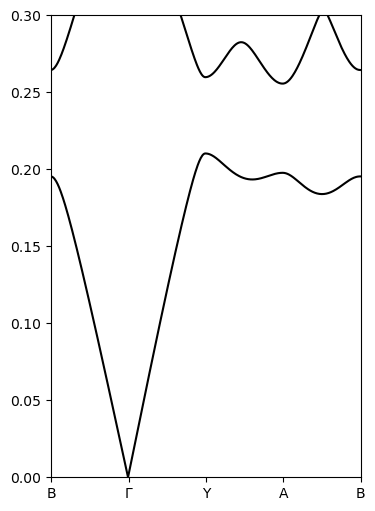

In [105]:
figure(figsize=(4, 6))
dispersion = dispersionsv_high_contrast[464]
plot(dispersion[:, 1:3], color="black");
ylim(0, 0.3)
xlim(0, 404);
xticks([Gamma_point_idxs..., A_point_idxs..., B_point_idxs..., Y_point_idxs...], [repeat(["Γ"], length(Gamma_point_idxs))...,
        repeat(["A"], length(A_point_idxs))..., repeat(["B"], length(B_point_idxs))..., repeat(["Y"], length(Y_point_idxs))...])
;


In [110]:
kpts = Vector{Float64}()
io = open(edge_state_log_dir*"dim2-sg2-100464-res32-tm.log")
logstr = read(io, String)
dispersion_str = logs_to_dispersion(logstr, "tm");
dispersion = readdlm(IOBuffer(dispersion_str), ',')[:, 6:end]
edge_state_dispersion = sort(dispersion, dims=2)
kpts = readdlm(IOBuffer(dispersion_str), ',')[:, 2:4];

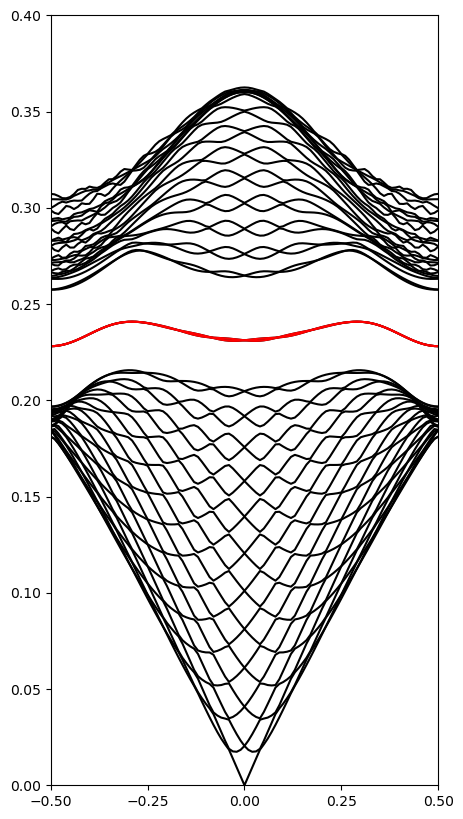

In [117]:
figure(figsize=(5, 10))
plot(kpts[:, 1], edge_state_dispersion, color="black")
plot(kpts[:, 1], edge_state_dispersion[:, [24, 25]], color="red")

ylim(0, 0.4)
xlim(-0.5, 0.5)
xticks([-0.5, -0.25, 0, 0.25, 0.5]);

# Compare PhC unit cells

In [118]:
idx = 464
filename = "dim2-sg2-100464-res32-tm-epsilon.h5"
f = h5open(edge_state_dir * filename, "r")
epsilon1 = f["data"][];
close(f)


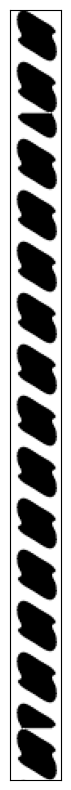

In [126]:
figure(figsize=(10, 10))
imshow(epsilon1, cmap="Greys")
ylim(32*5, 32*20)
yticks([])
xticks([]);

In [127]:
idx = 464
filename = "dim2-sg2-$(idx+20000*5)-res64-tm-epsilon.h5"
f = h5open(contrast_dir * filename, "r")
epsilon1 = f["data"][];
close(f)

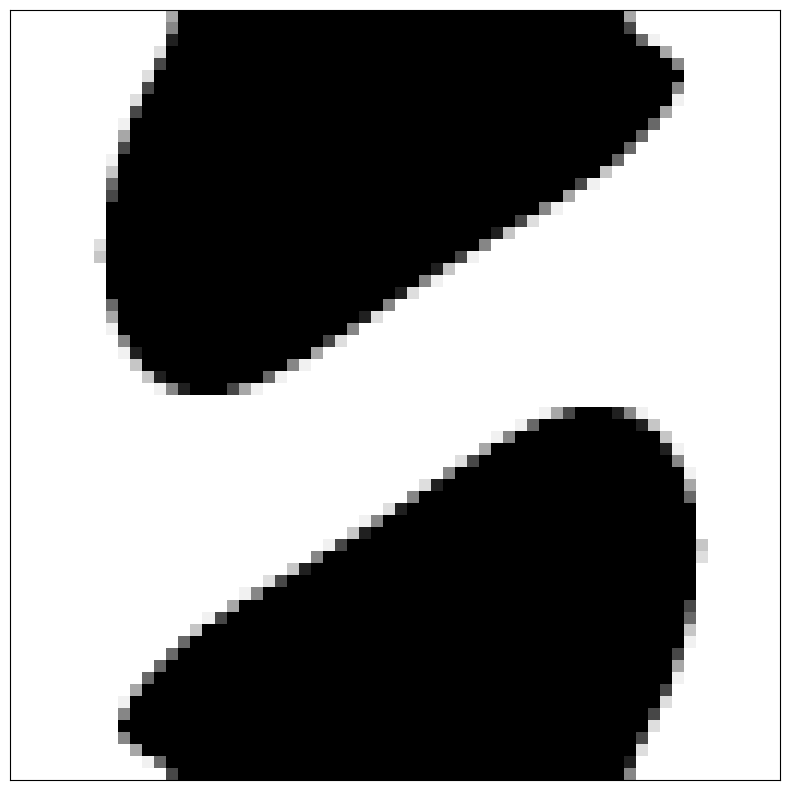

In [129]:
figure(figsize=(10, 10))
imshow(epsilon1, cmap="Greys")
#ylim(32*5, 32*20)
yticks([])
xticks([]);